In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 모델 분석 및 시각화 도구
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import xml.etree.ElementTree as ET
import os
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 모델 설계
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
import os
import numpy as np
from PIL import Image

# 데이터셋 경로
dataset_path = "/content/drive/MyDrive/Dataset"

# 클래스와 라벨 매핑
classes = {"healthy_strawberry": 0, "infected_strawberry": 1}

# 데이터와 라벨 저장
image_data = []
labels = []

# 폴더를 순회하며 이미지 로드 및 라벨링
for class_name, label in classes.items():
    class_folder = os.path.join(dataset_path, class_name)
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)

        # 이미지 로드 (필요에 따라 리사이즈)
        try:
            img = Image.open(image_path).convert("RGB")  # RGB로 변환
            img = img.resize((128, 128))  # 이미지 크기 변경 (예: 128x128)
            image_data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"이미지 로드 실패: {image_path}, 오류: {e}")

# 배열로 변환
X = np.array(image_data)
y = np.array(labels)

# 라벨 분포 출력
print("라벨 분포:", dict(zip(*np.unique(y, return_counts=True))))


라벨 분포: {0: 1015, 1: 976}


데이터 증강 이후 밸런스 확인: {0: 3005, 1: 976}


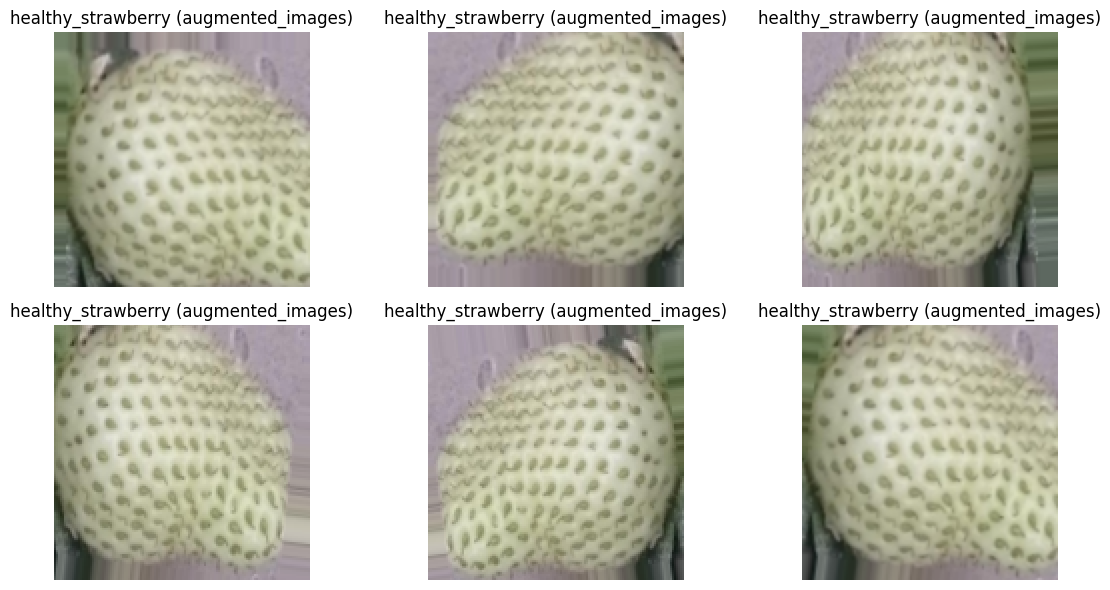

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import numpy as np

# 데이터 증강 객체
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# healthy_strawberry와 infected_strawberry 이미지를 분리
healthy_images = X[y == 0]  # healthy_strawberry
infected_images = X[y == 1]  # infected_strawberry

augmented_images = []
augmented_labels = []

# 'healthy_strawberry' 이미지를 증강하여 'infected_strawberry' 개수에 맞추기
for image in healthy_images:
    image = image.reshape((1, *image.shape))  # (1, 128, 128, 3)로 변환
    for batch in datagen.flow(image, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(0)  # healthy_strawberry 라벨
        if len(augmented_images) >= len(infected_images):  # infected_strawberry 개수만큼 증강
            break

# 증강된 이미지를 numpy 배열로 변환
augmented_images = np.array(augmented_images, dtype=np.uint8)
augmented_labels = np.array(augmented_labels)

# 원본 이미지와 증강된 이미지를 합침
X_balanced = np.concatenate([X, augmented_images], axis=0)
y_balanced = np.concatenate([y, augmented_labels], axis=0)

# 데이터 섞기
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# 데이터 증강 이후 라벨 분포 확인
print("데이터 증강 이후 밸런스 확인:", dict(zip(*np.unique(y_balanced, return_counts=True))))

# 증강된 이미지 몇 개를 출력
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # BGR -> RGB 변환
    image = augmented_images[i]
    plt.imshow(image)  # 이제 이미지는 RGB로 출력됩니다.
    plt.title("healthy_strawberry (augmented_images)")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
# 정규화 (0 ~ 1)
X_normalized = X_balanced / 255.0

# 테스트셋의 양이 적어 6:4 비율로 나누었습니다.
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_balanced, test_size=0.4, random_state=42)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (2388, 128, 128, 3), Training labels shape: (2388,)
Testing data shape: (1593, 128, 128, 3), Testing labels shape: (1593,)


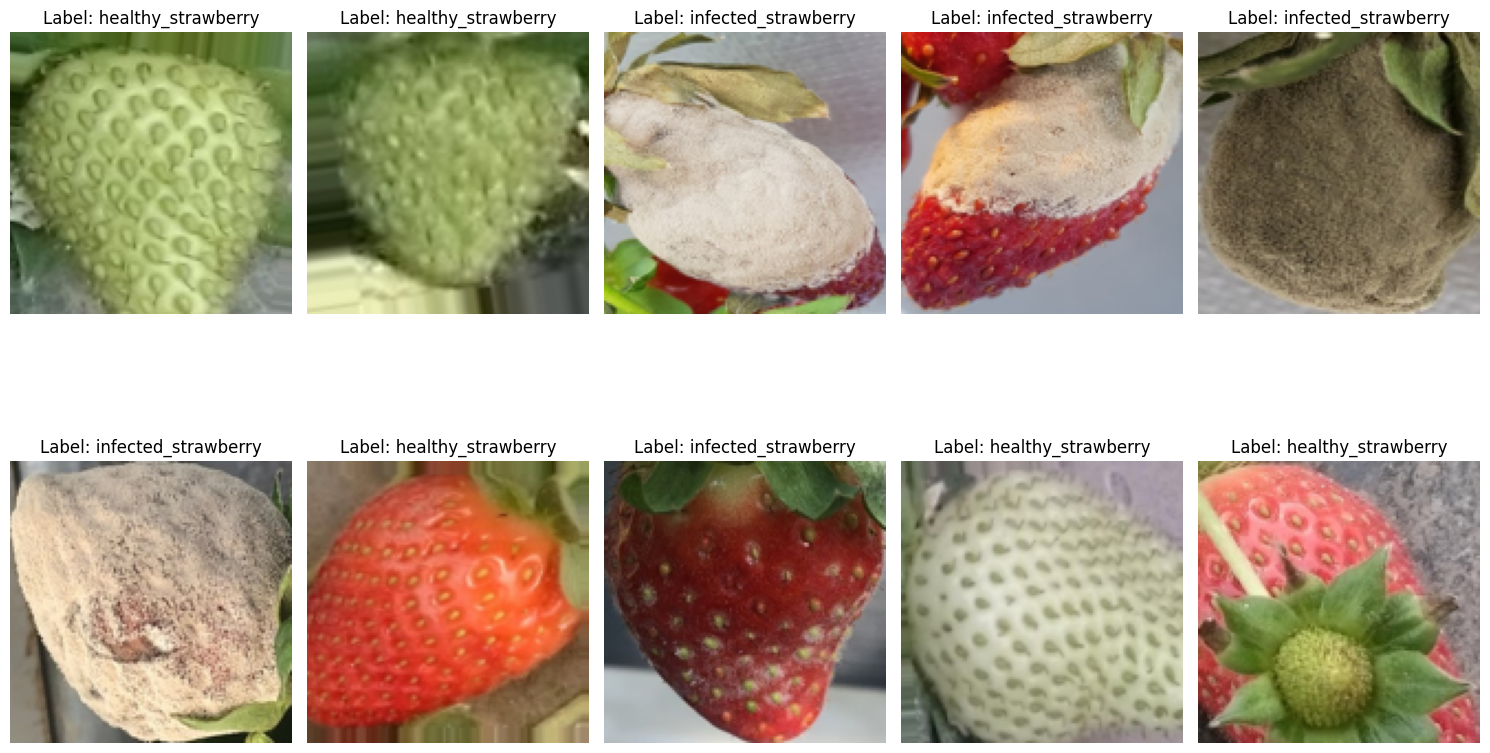

In [7]:
def visualize_images(X, y, num_images=10):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X)), num_images)

    for i, idx in enumerate(indices):
        image = X[idx].reshape(128, 128, 3)

        label_index = y[idx]
        # 라벨을 직접 사용 (이미 인코딩된 상태)
        label = "healthy_strawberry" if label_index == 0 else "infected_strawberry"

        plt.subplot(2, 5, i + 1)
        plt.imshow(image.astype('uint8'))  # 이미지는 RGB 형식으로 출력됨
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(X_balanced, y_balanced, num_images=10)

In [8]:
from collections import Counter

# 클래스별 라벨 카운트 출력
label_counts = Counter(y_balanced)
print("Training data label counts:")
for label, count in label_counts.items():
    class_name = "healthy_strawberry" if label == 0 else "infected_strawberry"
    print(f"{class_name}: {count}")

# 데이터셋의 라벨을 샘플로 확인
print("\nSample labels:")
sample_labels = ["healthy_strawberry" if label == 0 else "infected_strawberry" for label in y_balanced[:10]]
print(sample_labels)  # 앞 10개 라벨 출력

Training data label counts:
healthy_strawberry: 3005
infected_strawberry: 976

Sample labels:
['healthy_strawberry', 'healthy_strawberry', 'healthy_strawberry', 'healthy_strawberry', 'healthy_strawberry', 'infected_strawberry', 'healthy_strawberry', 'healthy_strawberry', 'healthy_strawberry', 'infected_strawberry']


In [9]:
# 모델 결과 시각화 함수
def plot_history(history, main_title):
    plt.figure(figsize=(12, 5))

    # 전체 타이틀
    plt.suptitle(main_title, fontsize=20, fontweight='bold')

    # 정확도
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()

    # 손실
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.92])  # 전체 타이틀 공간 확보
    plt.show()

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',   # 검증 손실을 모니터링
    patience=10,           # 개선이 없을 때 대기할 에포크 수
    restore_best_weights=True  # 최적의 가중치를 복원
)

In [10]:
# 모델 구성
model_single = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # 3D 데이터를 1D로 변환
    Dense(1, activation='sigmoid')      # 이진 분류용 출력층
])

model_single.summary()

# 모델 학습 설정
model_single.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
hist = model_single.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # 조기 종료 콜백 추가
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          49,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,153 (192.00 KB)

 Trainable params: 49,153 (192.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6786 - loss: 4.7957 - val_accuracy: 0.2511 - val_loss: 20.4984
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7003 - loss: 3.7318 - val_accuracy: 0.7659 - val_loss: 3.7881
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7712 - loss: 2.7200 - val_accuracy: 0.6805 - val_loss: 1.6012
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7650 - loss: 2.7250 - val_accuracy: 0.8556 - val_loss: 0.8498
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7700 - loss: 2.3144 - val_accuracy: 0.8569 - val_loss: 0.7585
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8136 - loss: 1.9992 - val_accuracy: 0.8104 - val_loss: 1.7656
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7909 - loss: 2.1225 - val_accuracy: 0.7508 - val_loss: 7.7477
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7943 - loss: 2.3286 - val_accuracy: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy: 0.8569


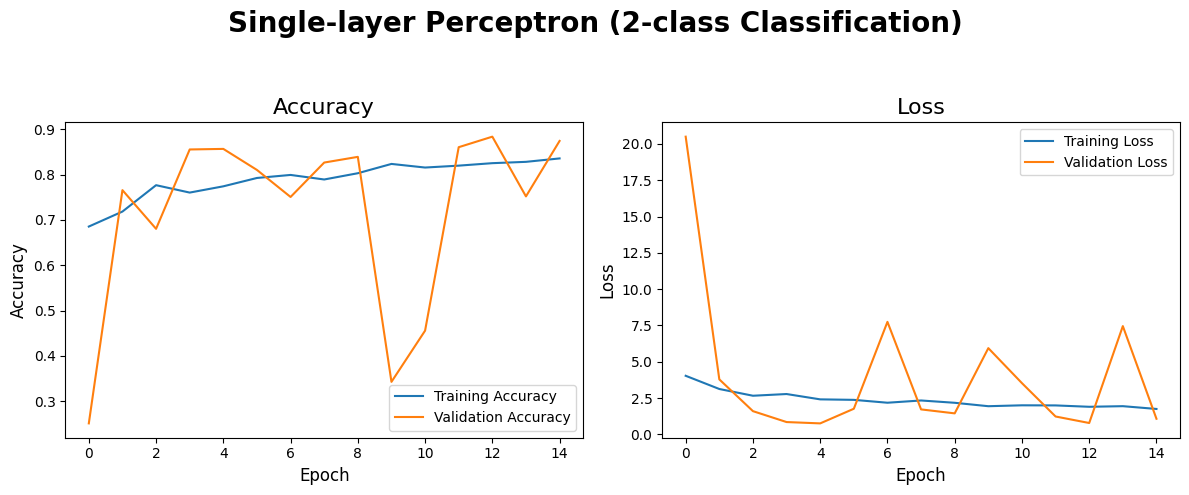

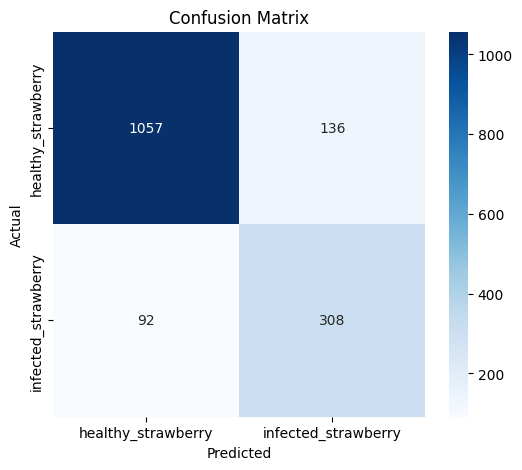

Classification Report:
                     precision    recall  f1-score   support

 healthy_strawberry       0.92      0.89      0.90      1193
infected_strawberry       0.69      0.77      0.73       400

           accuracy                           0.86      1593
          macro avg       0.81      0.83      0.82      1593
       weighted avg       0.86      0.86      0.86      1593



In [11]:
# 예측값 (확률)
y_pred = model_single.predict(X_test)
# 확률이 0.5보다 크면 클래스 1, 그렇지 않으면 클래스 0
y_pred_classes = (y_pred > 0.5).astype(int)  # 확률을 기준으로 클래스 예측

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# 학습 히스토리 시각화
plot_history(hist.history, "Single-layer Perceptron (2-class Classification)")

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_classes)  # y_test와 y_pred_classes 비교

# 혼동 행렬 시각화 (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy_strawberry', 'infected_strawberry'], yticklabels=['healthy_strawberry', 'infected_strawberry'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 혼동 행렬 리포트 추가
report = classification_report(y_test, y_pred_classes, target_names=['healthy_strawberry', 'infected_strawberry'])
print("Classification Report:")
print(report)

In [14]:
from tensorflow.keras.applications import ResNet50

X_train_reshaped = X_train.reshape(-1, 128, 128, 3)
X_test_reshaped = X_test.reshape(-1, 128, 128, 3)

# ResNet50 모델 불러오기
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom top layers for your specific dataset
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base model with custom layers
resnet50_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the transfer learning model
transfer_optimizer = Adam(learning_rate=0.0001)
resnet50_model.compile(optimizer=transfer_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the transfer learning model summary
resnet50_model.summary()

# Train the transfer learning model
hist = resnet50_model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping],
    verbose=2
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
150/150 - 23s - 152ms/step - accuracy: 0.7140 - loss: 0.6043 - val_accuracy: 0.7489 - val_loss: 0.5553
Epoch 2/50
150/150 - 9s - 59ms/step - accuracy: 0.7554 - loss: 0.5643 - val_accuracy: 0.7489 - val_loss: 0.5423
Epoch 3/50
150/150 - 5s - 31ms/step - accuracy: 0.7542 - loss: 0.5489 - val_accuracy: 0.7489 - val_loss: 0.5319
Epoch 4/50
150/150 - 5s - 32ms/step - accuracy: 0.7588 - loss: 0.5362 - val_accuracy: 0.7489 - val_loss: 0.5197
Epoch 5/50
150/150 - 6s - 39ms/step - accuracy: 0.7609 - loss: 0.5261 - val_accuracy: 0.7495 - val_loss: 0.5086
Epoch 6/50
150/150 - 7s - 47ms/step - accuracy: 0.7609 - loss: 0.5080 - val_accuracy: 0.7508 - val_loss: 0.4941
Epoch 7/50
150/150 - 8s - 52ms/step - accuracy: 0.7663 - loss: 0.4959 - val_accuracy: 0.7571 - val_loss: 0.4812
Epoch 8/50
150/150 - 6s - 40ms/step - accuracy: 0.7676 - loss: 0.4870 - val_accuracy: 0.7640 - val_loss: 0.4680
Epoch 9/50
150/150 - 5s - 36ms/step - accuracy: 0.7755 - loss: 0.4705 - val_accuracy: 0.7715 - val_los

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.9560


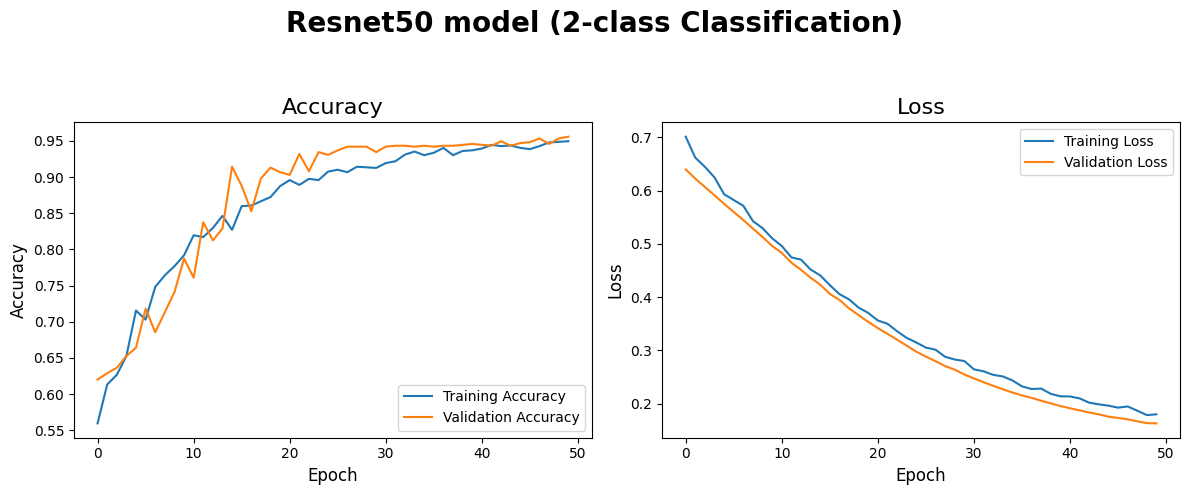

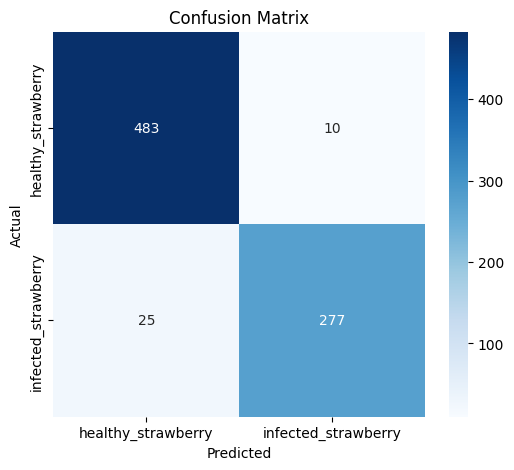

Classification Report:
                     precision    recall  f1-score   support

 healthy_strawberry       0.95      0.98      0.97       493
infected_strawberry       0.97      0.92      0.94       302

           accuracy                           0.96       795
          macro avg       0.96      0.95      0.95       795
       weighted avg       0.96      0.96      0.96       795



In [ ]:
y_pred = resnet50_model.predict(X_test_reshaped)
y_pred_classes = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

plot_history(hist.history, "Resnet50 model (2-class Classification)")

cm = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화 (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy_strawberry', 'infected_strawberry'], yticklabels=['healthy_strawberry', 'infected_strawberry'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=['healthy_strawberry', 'infected_strawberry'])
print("Classification Report:")
print(report)